# Wind Turbine Power Generation Forecasting

Train dataset contains hourly meteorological data along with power output measurements collected between January 2013 and December 2016. The data includes variables such as temperature, relative humidity, wind speed at various altitudes, and power generated at different locations.

## Prepare workspace

1. Import dependencies.

In [1]:
import keras
import numpy as np
import pandas as pd
import sklearn

from lib.layer.layer_def import Dense, Input
from lib.util.loss_function import MEAN_SQUARED_ERROR
from lib.model.seq_model import SeqNet, ValidationData
from lib.optimizer.genetic_optimizer import GeneticOptimizer
from lib.optimizer.gradient_descent_optimizer import GradientDescentOptimizer
from lib.util.progress_tracker import NotebookProgressTracker
from lib.util.lr_scheduler import ConstantLrScheduler
from lib.model.anfis import Anfis
from lib.util.member_function import GaussianMF
from lib.util.activation_function import RELU_ACTIVATION

from src.data.wind_turbine import wind_turbine_dataset
from src.definitions import EXTERNAL_DATA_FOLDER
from src.visualization.plot import (
    plot_loss_and_val_loss,
    plot_diff,
    plot_loss_history,
    plot_member_fun,
)

from sklearn.discriminant_analysis import StandardScaler

2. Download and process `sudhanvahg/wind-turbine-power-generation-forecasting` dataset.

In [2]:
archive = wind_turbine_dataset.download_wind_turbine_dataset(EXTERNAL_DATA_FOLDER)

3. Split on train/test/validate. Extract free and bound variables. Scale input.

In [3]:
scaler = StandardScaler()

dataset = wind_turbine_dataset.process_wind_turbine_dataset(
    archive,
    scaler=scaler,
)

dataset.head(5)

,Temp_2m,RelHum_2m,DP_2m,WS_10m,WS_100m,WD_10m,WD_100m,WG_10m,Power,Location_1,Location_2,Location_3,Location_4
0,-0.804021,0.837857,-0.562194,-1.355386,-1.850563,-0.555885,-0.391588,-1.845008,0.151429,1,0,0,0
1,-0.808581,0.896680,-0.552661,-1.049536,-0.957421,-0.505925,-0.431150,-1.017793,0.133128,1,0,0,0
2,-0.881539,1.190795,-0.562194,-1.424449,-1.353283,-0.535901,-0.510276,-1.348679,0.114574,1,0,0,0
3,-0.854179,1.014326,-0.571727,-1.424449,-1.382727,-1.435186,-0.955355,-1.789861,0.095579,1,0,0,0
4,-0.858739,1.014326,-0.581260,-0.847281,-0.813472,-1.435186,-1.163059,-1.128089,0.076309,1,0,0,0


In [4]:
# x_train, y_train, x_valid, y_valid, x_test, y_test = (
#     wind_turbine_dataset.window_and_split_turbine_dataset(
#         dataset=dataset, test_train_ratio=0.8, train_valid_ratio=0.9, window_size=10
#     )
# )

x_train, y_train, x_valid, y_valid, x_test, y_test = (
    wind_turbine_dataset.split_turbine_dataset(
        dataset=dataset, test_train_ratio=0.8, train_valid_ratio=0.9
    )
)

print("x_train = " + str(x_train.shape))
print("y_train = " + str(y_train.shape))
print("x_valid = " + str(x_valid.shape))
print("y_valid = " + str(y_valid.shape))
print("x_test = " + str(x_test.shape))
print("y_test = " + str(y_test.shape))

validation_data = ValidationData(x_valid, y_valid)

x_train = (12, 100915)
y_train = (1, 100915)
x_valid = (12, 11213)
y_valid = (1, 11213)
x_test = (12, 28032)
y_test = (1, 28032)


## Train NN using genetic optimizer

1. Define neural network.

In [5]:
model = SeqNet(
    layers=[
        Input(x_train.shape[0]),
        Dense(1),
    ]
)

opt = GeneticOptimizer(
    population_size=200, mutation_rate=0.5, mutation_decay=0.005
)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    progress_tracker=NotebookProgressTracker(),
)

2. Train neural network.

Progress:   0%|          | 0/300 [00:00<?, ?it/s]

loss = 0.1834073919401001


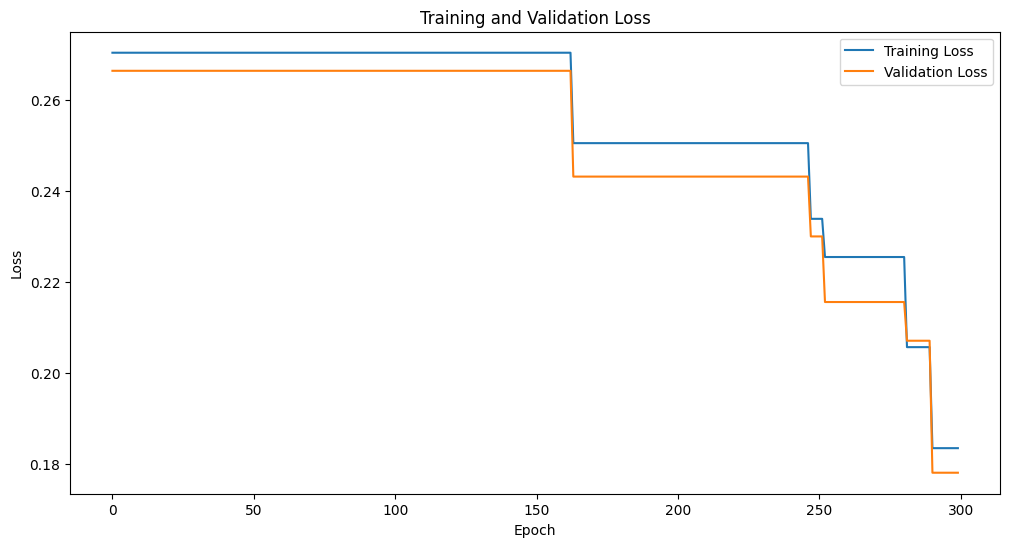

In [6]:
trained_model = compiled_model.fit(
    x_train, y_train, 300, validation_data=validation_data
)

print("loss = " + str(trained_model.train_loss()))

plot_loss_and_val_loss(trained_model)

3. Test neural network.

loss = 0.17901448458467256
R2 score = -4.269646785881662


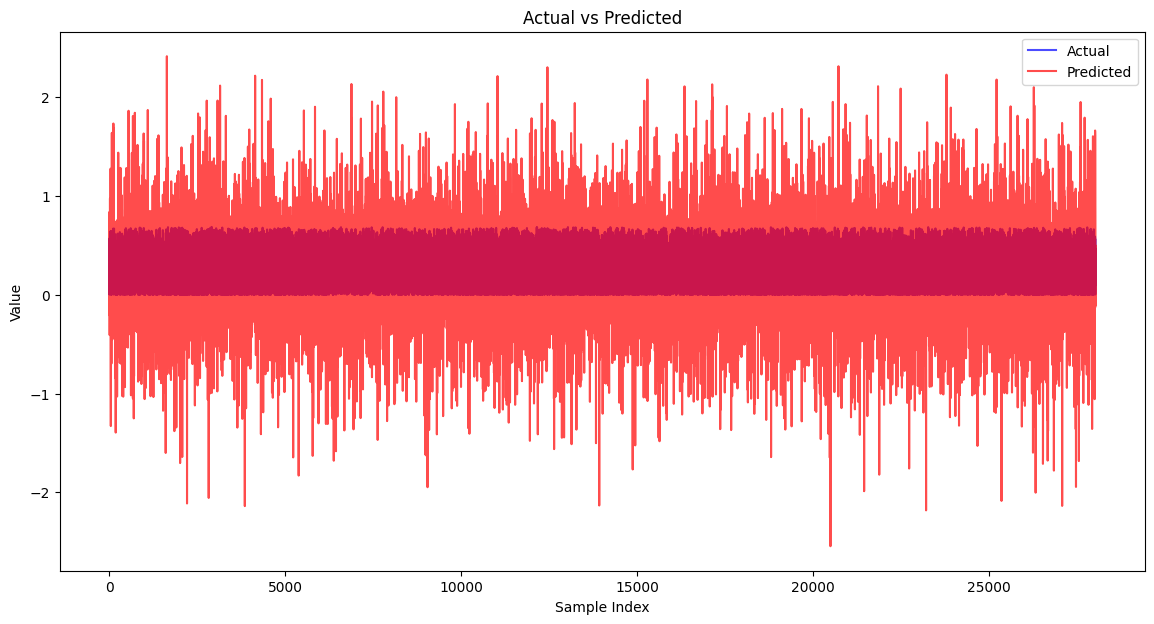

In [7]:
y_predicted = trained_model.predict(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

4. Build report

In [8]:
delta = y_test - y_predicted

report = pd.DataFrame(
    {
        "Power RO": y_test.flatten(),
        "Power PO": y_predicted.flatten(),
        "DELTA": delta.flatten(),
        "DELTA^2": np.square(delta.flatten()),
    }
)

report_head = report.head(12)

display(report_head)

print("Delta total = " + str(report_head["DELTA"].sum()))
print("Delta^2 total = " + str(report_head["DELTA^2"].sum()))

,Power RO,Power PO,DELTA,DELTA^2
0,0.114842,0.323939,-0.209097,0.043722
1,0.137408,0.383161,-0.245754,0.060395
2,0.136797,0.280621,-0.143823,0.020685
3,0.162115,0.303988,-0.141873,0.020128
4,0.245137,0.528473,-0.283336,0.080279
5,0.003589,0.163518,-0.159928,0.025577
6,0.441730,0.082646,0.359084,0.128941
7,0.515333,0.598760,-0.083427,0.006960
8,0.012517,0.451318,-0.438800,0.192546
9,0.568941,0.159648,0.409293,0.167521


Delta total = -1.501654903082283
Delta^2 total = 0.9161265324091503


## Train NN using gradient descent optimizer

1. Define Neural network

In [21]:
model = SeqNet(
    layers=[
        Input(x_train.shape[0]),
        Dense(units_count=64, activation_fun=RELU_ACTIVATION),
        Dense(units_count=64, activation_fun=RELU_ACTIVATION),
        Dense(1),
    ]
)

lr_scheduler = ConstantLrScheduler(1e-3)
opt = GradientDescentOptimizer(lr_scheduler=lr_scheduler, momentum_decay=0.8)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    lr_scheduler=lr_scheduler,
    progress_tracker=NotebookProgressTracker(),
)

2. Train neural network.

Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

loss = 0.23319923804916243


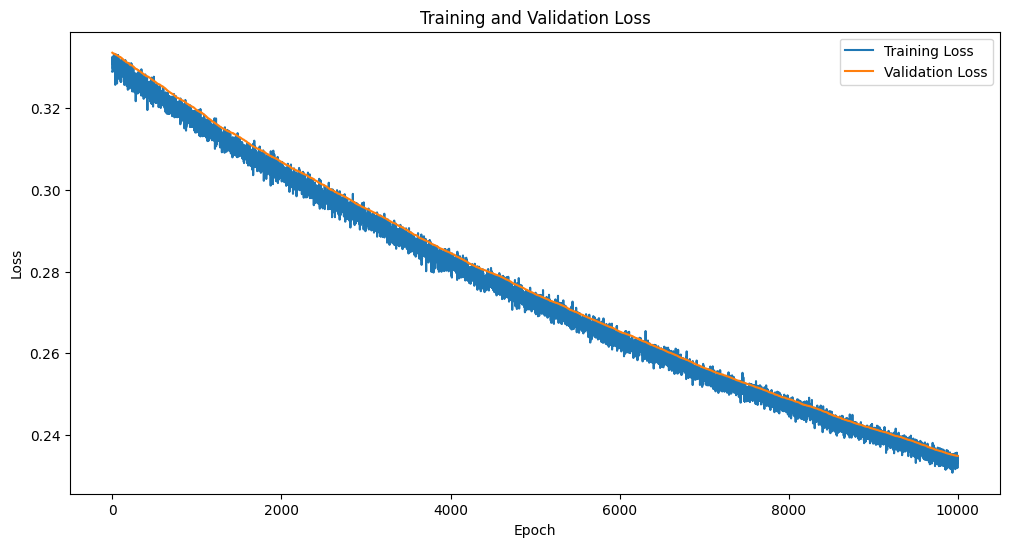

In [24]:
trained_model = compiled_model.fit(
    x_train, y_train, 10_000, validation_data=validation_data, batch_size=4048
)

print("loss = " + str(trained_model.train_loss()))

plot_loss_and_val_loss(trained_model)

3. Test neural network.

loss = 0.23185166055848272
R2 score = -5.825013968550925


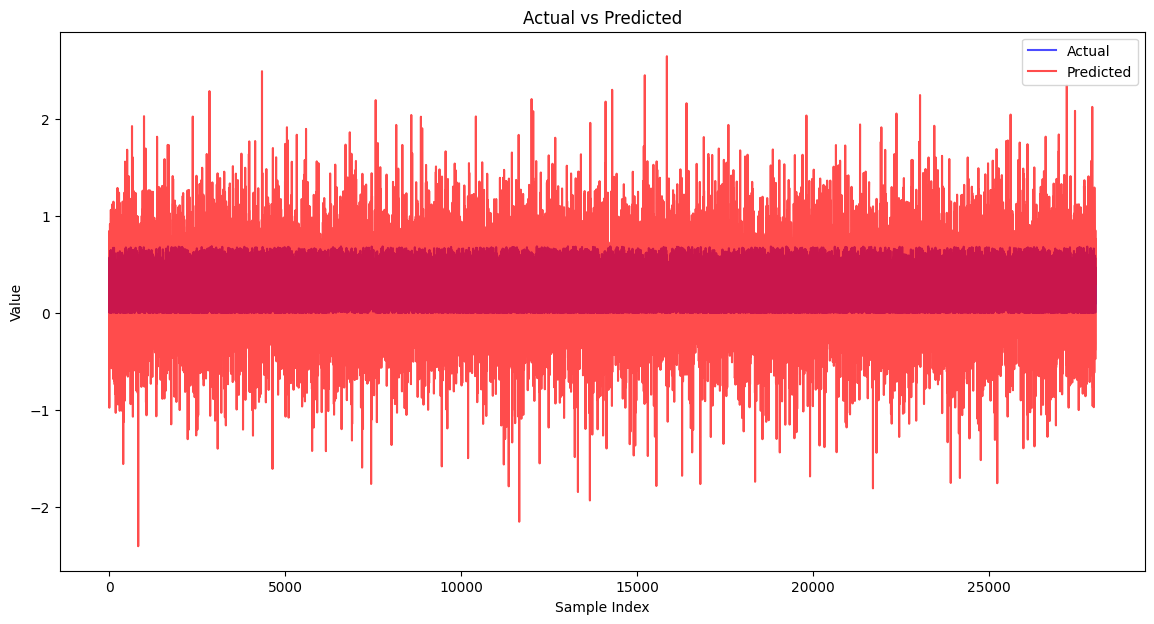

In [25]:
y_predicted = trained_model.predict(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

4. Build report

In [27]:
delta = y_test - y_predicted

report = pd.DataFrame(
    {
        "Power RO": y_test.flatten(),
        "Power PO": y_predicted.flatten(),
        "DELTA": delta.flatten(),
        "DELTA^2": np.square(delta.flatten()),
    }
)

report_head = report.head(12)

display(report_head)

print("Delta total = " + str(report_head["DELTA"].sum()))
print("Delta^2 total = " + str(report_head["DELTA^2"].sum()))

,Power RO,Power PO,DELTA,DELTA^2
0,0.114842,0.359373,-0.244531,0.059795
1,0.137408,0.491376,-0.353968,0.125294
2,0.136797,0.600770,-0.463973,0.215271
3,0.162115,-0.134381,0.296496,0.087910
4,0.245137,0.331217,-0.086080,0.007410
5,0.003589,-0.295589,0.299178,0.089507
6,0.441730,-0.977248,1.418978,2.013500
7,0.515333,0.611911,-0.096578,0.009327
8,0.012517,0.658316,-0.645799,0.417056
9,0.568941,0.323551,0.245390,0.060216


Delta total = -0.48858729509807286
Delta^2 total = 3.6391990948667363


## Train NN using tensorflow and Adam optimizer

1. Define Neural network

In [5]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(x_train.shape[0],)),
        keras.layers.Dense(units=64, activation="relu"),
        keras.layers.Dense(units=64, activation="relu"),
        keras.layers.Dense(units=1),
    ]
)

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,057 (19.75 KB)

 Trainable params: 5,057 (19.75 KB)

 Non-trainable params: 0 (0.00 B)

2. Train neural network.

In [6]:
history = model.fit(
    x_train.T, y_train.reshape(-1), epochs=100, batch_size=32, verbose=1
)

Epoch 1/100
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 1s 272us/step - loss: 0.0180
Epoch 2/100
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 1s 249us/step - loss: 0.0137
Epoch 3/100
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 1s 243us/step - loss: 0.0134
Epoch 4/100
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step - loss: 0.0133
Epoch 5/100
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 1s 249us/step - loss: 0.0131
Epoch 6/100
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 1s 262us/step - loss: 0.0130
Epoch 7/100
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 1s 252us/step - loss: 0.0131
Epoch 8/100
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step - loss: 0.0129
Epoch 9/100
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step - loss: 0.0128
Epoch 10/100
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 1s 249us/step - loss: 0.0127
Epoch 11/100
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - loss: 0.0126
Epoch 12/100
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 1s 257us/step - loss: 0.0126
Epoch 13/100
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - loss: 0.0127
Epoch 14/100
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 1s 248us/step - 

3. Test neural network.

876/876 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
loss = 0.056789048340078925
R2 score = 0.6424965983181735


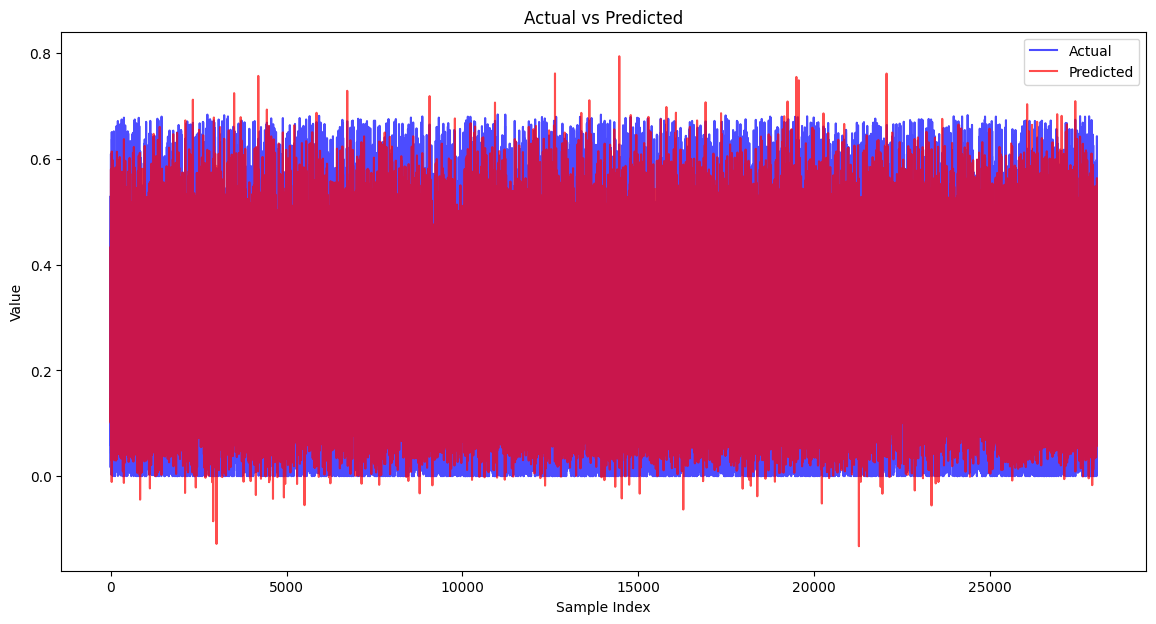

In [7]:
y_predicted = model.predict(x_test.T)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

4. Build report

In [8]:
delta = y_test.flatten() - y_predicted.flatten()

report = pd.DataFrame(
    {
        "Power RO": y_test.flatten(),
        "Power PO": y_predicted.flatten(),
        "DELTA": delta.flatten(),
        "DELTA^2": np.square(delta.flatten()),
    }
)

report_head = report.head(12)

display(report_head)

print("Delta total = " + str(report_head["DELTA"].sum()))
print("Delta^2 total = " + str(report_head["DELTA^2"].sum()))

,Power RO,Power PO,DELTA,DELTA^2
0,0.156573,0.144720,0.011853,1.404896e-04
1,0.016558,0.102467,-0.085909,7.380285e-03
2,0.167796,0.268650,-0.100854,1.017144e-02
3,0.529920,0.433951,0.095969,9.210061e-03
4,0.303282,0.361053,-0.057771,3.337518e-03
5,0.058076,0.100079,-0.042003,1.764248e-03
6,0.464046,0.349288,0.114758,1.316943e-02
7,0.081853,0.138866,-0.057013,3.250514e-03
8,0.427289,0.377953,0.049336,2.434032e-03
9,0.161520,0.161522,-0.000002,3.679678e-12


Delta total = -0.19333407939389777
Delta^2 total = 0.07450522401843315


## Train ANFIS using GD optimizer

1. Define Neural network

In [9]:
mf = [
    [GaussianMF(-1.5, 2), GaussianMF(1, 1.5)],
    [GaussianMF(-1.5, 2), GaussianMF(1, 1.5)],
    [GaussianMF(-1.5, 2), GaussianMF(1, 1.5)],
    [GaussianMF(0, 3), GaussianMF(5, 3)],
    [GaussianMF(0, 3), GaussianMF(3, 3)],
    [GaussianMF(-0.5, 1), GaussianMF(0.5, 2)],
    [GaussianMF(-1, 1), GaussianMF(1, 1)],
    [GaussianMF(-0.5, 2), GaussianMF(2, 3)],
    [GaussianMF(0, 0.75), GaussianMF(1, 0.75)],
    [GaussianMF(0, 0.75), GaussianMF(1, 0.75)],
    [GaussianMF(0, 0.75), GaussianMF(1, 0.75)],
    [GaussianMF(0, 0.75), GaussianMF(1, 0.75)],
]

model = Anfis(mem_fun=mf, loss_fun=MEAN_SQUARED_ERROR, learning_rate=1e-3)

2. Train neural network.

Progress:   0%|          | 0/100 [00:00<?, ?it/s]

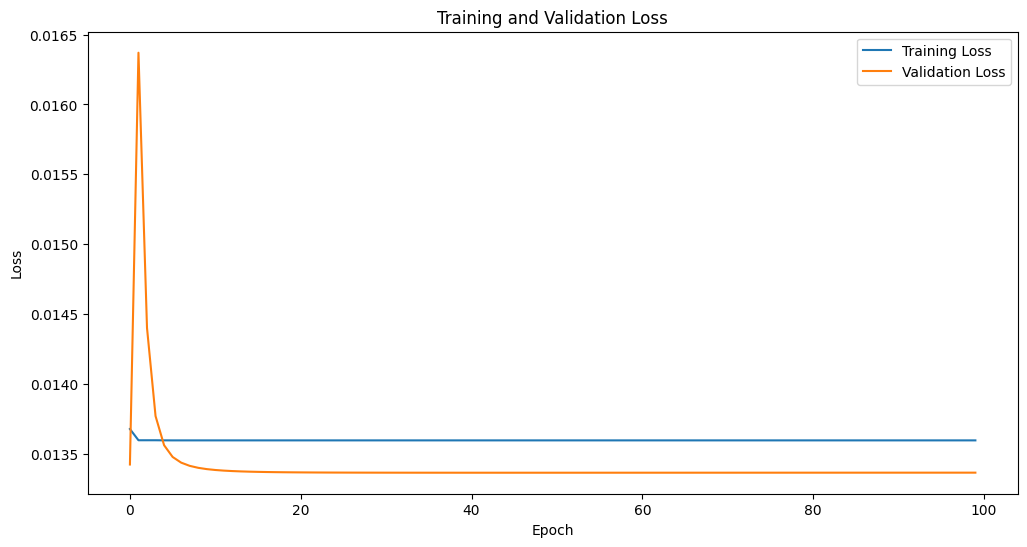

In [10]:
history = model.fit(
    x_train, y_train.reshape(-1), epochs=100, validation_data=validation_data
)

plot_loss_history(history)

3. Test neural network.

loss = 0.013722079913187956
R2 score = 0.6001026300568041


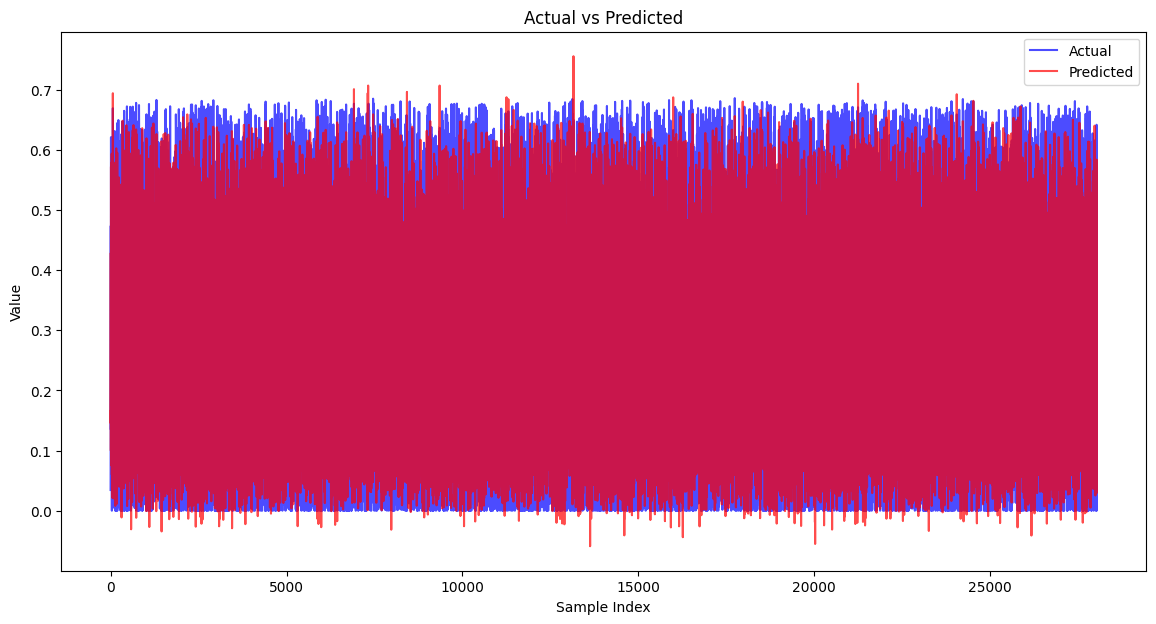

In [7]:
y_predicted = model.forward(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

4. Show member functions

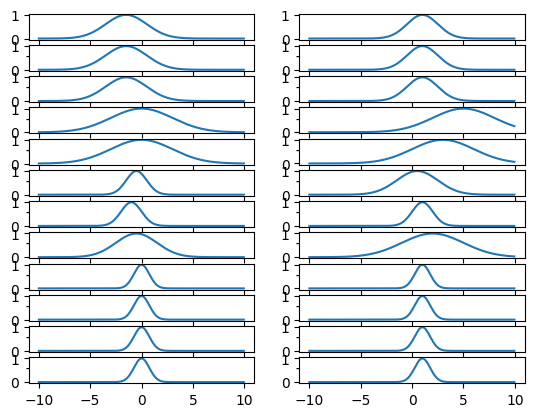

In [9]:
plot_member_fun(mf)